
# Homework Week 3

## ml-zoomcamp 2023 cohort

<hr>

In [61]:
## Importing libraries ##

# Data manipulation
import pandas as pd
import numpy as np

# Data visualisation
import seaborn as sns
from matplotlib import pyplot as plt

# Getting data
import wget

In [62]:
# Importing and loading the data
df = pd.read_csv('data.csv')

In [63]:
## Data preperation ##

# Cleaning series titles
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Renaming MSRP to price (replacing)
df['price'] = df['msrp']

# Deleting MSRP
del df['msrp']


In [64]:
# Array of series of interest
categories = ['make', 'model', 'year', 'engine_hp', 'engine_cylinders', 'transmission_type',
              'vehicle_style', 'highway_mpg', 'city_mpg', 'price']

# Replacing NAs with 0
df = df[categories]
df = df.fillna(0)

### Question 1 - What is the most frequent observation (mode) for the column transmission_type?

In [65]:
# Using value_counts()
df.transmission_type.value_counts()

transmission_type
AUTOMATIC           8266
MANUAL              2935
AUTOMATED_MANUAL     626
DIRECT_DRIVE          68
UNKNOWN               19
Name: count, dtype: int64

In [66]:
# Using mode()
df.transmission_type.mode()

0    AUTOMATIC
Name: transmission_type, dtype: object

The most frequently observed transmission type is **automatic**

### Question 2 - Create correlation matrix for numerical features

In [67]:
numeric_type = list(df._get_numeric_data().columns)
numeric_type.remove('price')
df[numeric_type].corr().abs()

,year,engine_hp,engine_cylinders,highway_mpg,city_mpg
year,1.000000,0.338714,0.040708,0.258240,0.198171
engine_hp,0.338714,1.000000,0.774851,0.415707,0.424918
engine_cylinders,0.040708,0.774851,1.000000,0.614541,0.587306
highway_mpg,0.258240,0.415707,0.614541,1.000000,0.886829
city_mpg,0.198171,0.424918,0.587306,0.886829,1.000000


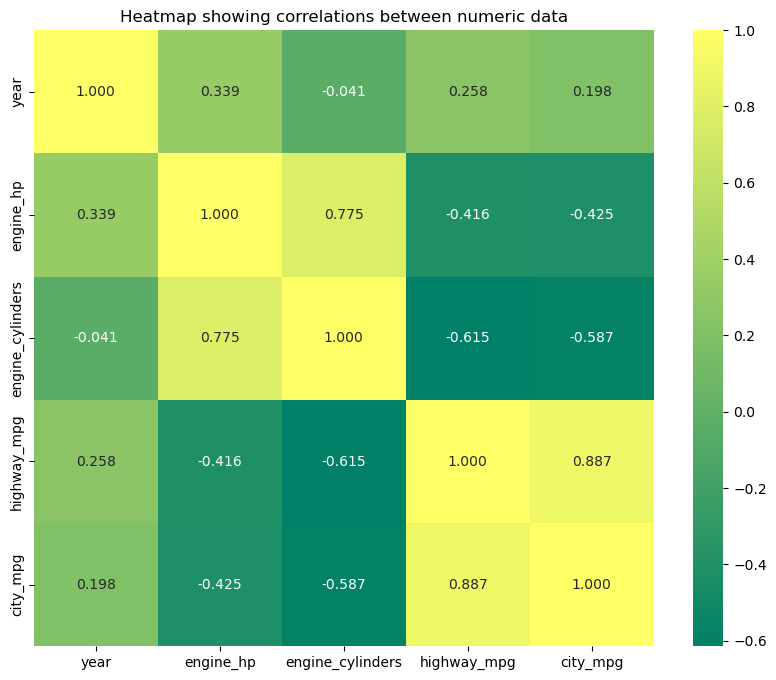

In [68]:
plt.figure(figsize=(10, 8), dpi=100)
sns.heatmap(df[numeric_type].corr(), cmap="summer", annot=True, fmt='.3f')
plt.title('Heatmap showing correlations between numeric data')
# plt.xticks(rotation=0) 
plt.show()

The correlation with largest magnitude is between **city_mpg** and **highway_mpg**

In [69]:
# Making 'price' binary using average price for classification
price_avg = df.price.mean()
above_average = (df.price >= price_avg).astype(int)
df['price'] = above_average

In [70]:
## Establishing validation framework ##

# Importing sklearn function to create 60/20/20 split
from sklearn.model_selection import train_test_split

# Creating splits
train_val, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(train_val, test_size=0.25, random_state=42)

# Dropping indecies
train_val = train_val.reset_index(drop=True)
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

# Target vectors
y_train_val = train_val.price
y_train = train.price
y_val = val.price
y_test = test.price

# Removing target vectors from feature matrices
del train_val['price']
del train['price']
del val['price']
del test['price']

train

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg
0,Mitsubishi,Endeavor,2011,225.0,6.0,AUTOMATIC,4dr SUV,19,15
1,Kia,Borrego,2009,276.0,6.0,AUTOMATIC,4dr SUV,21,17
2,Lamborghini,Gallardo,2012,570.0,10.0,MANUAL,Convertible,20,12
3,Chevrolet,Colorado,2016,200.0,4.0,AUTOMATIC,Crew Cab Pickup,27,20
4,Pontiac,Vibe,2009,158.0,4.0,AUTOMATIC,4dr Hatchback,26,20
...,...,...,...,...,...,...,...,...,...
7143,Toyota,Sienna,2016,266.0,6.0,AUTOMATIC,Passenger Minivan,25,18
7144,Chevrolet,HHR,2009,260.0,4.0,MANUAL,Wagon,29,21
7145,Hyundai,Veracruz,2012,260.0,6.0,AUTOMATIC,4dr SUV,22,17
7146,Mitsubishi,Expo,1993,136.0,4.0,MANUAL,2dr Hatchback,26,19


### Question 3 - Compute and compare mutual information scores

In [71]:
# Computing mutual information (from information theory) score for training set

# Importing function to compute mutual information score
from sklearn.metrics import mutual_info_score

# Function to calculating MI scores for each series (compared to average_price)
def mutual_info_price_score(series):
    return mutual_info_score(series, y_train)

round(train.apply(mutual_info_price_score).sort_values(ascending=False),2)

model                0.46
engine_hp            0.36
make                 0.24
engine_cylinders     0.12
vehicle_style        0.08
year                 0.07
city_mpg             0.06
highway_mpg          0.04
transmission_type    0.02
dtype: float64

The variable with the lowest mutual information score is **transmission_type**

### Question 4 - Logistic Regression

In [72]:
## Logistic Regression ##

# Importing function to perform One-hot encoding (feature extraction)
from sklearn.feature_extraction import DictVectorizer

# Importing function to perform logistic regression
from sklearn.linear_model import LogisticRegression

# Converting splits to dictionaries
train_dicts = train.to_dict(orient="records")
val_dicts = val.to_dict(orient="records")
test_dicts = test.to_dict(orient="records")

# Intitialising dictionary vectoriser
dv = DictVectorizer(sparse=False)

# Feature matrices
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

# Initialising model
model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)

# Training the model
model.fit(X_train, y_train)

# Calculating predictions for y_val
y_val_pred = model.predict_proba(X_val)[:,1]

# Classifying results
score_val = (y_val_pred >= 0.5).astype(int)

# Similarity between predictions and actual values (accuracy)
round((score_val == y_val).mean(),2)

accuracy_val = (score_val == y_val).mean()

The accuracy of our base model is quite high at **0.95**

### Question 5 - Least Useful Feature

In [73]:
## Logistic Regression ##

# Importing function to perform One-hot encoding (feature extraction)
from sklearn.feature_extraction import DictVectorizer

# Importing function to perform logistic regression
from sklearn.linear_model import LogisticRegression

features = ['year', 'engine_hp', 'transmission_type', 'city_mpg']

for i in features:

    train_temp = train.copy()
    val_temp = val.copy()

    del train_temp[i]
    del val_temp[i]

    # Converting splits to dictionaries
    train_dicts = train_temp.to_dict(orient="records")
    val_dicts = val_temp.to_dict(orient="records")

    # Intitialising dictionary vectoriser
    dv = DictVectorizer(sparse=False)

    # Feature matrices
    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    # Initialising model
    model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)

    # Training the model
    model.fit(X_train, y_train)

    # Calculating predictions for y_val
    y_val_pred = model.predict_proba(X_val)[:,1]

    # Classifying results
    score_val = (y_val_pred >= 0.5).astype(int)

    # Similarity between predictions and actual values (accuracy)
    print('Feature removed: {0:<20} Accuracy: {1:<10} Difference: {2:<10}'.
          format(i,round(((score_val == y_val).mean()),2), (accuracy_val - ((score_val == y_val).mean()))))

Feature removed: year                 Accuracy: 0.95       Difference: -0.0016785564414604215
Feature removed: engine_hp            Accuracy: 0.93       Difference: 0.015946286193873282
Feature removed: transmission_type    Accuracy: 0.95       Difference: 0.0012589173310951773
Feature removed: city_mpg             Accuracy: 0.95       Difference: 0.0004196391103650221


**city_mpg** is the feature which, upon being removed, results in the smallest difference in accuracy

### Question 6 - Ridge Regression

In [74]:
# Starting from the top with the raw data
df = pd.read_csv('data.csv')

# Cleaning series titles
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Renaming MSRP to price (replacing)
df['price'] = df['msrp']

# Deleting MSRP
del df['msrp']

# Reducing dataframe to variables of interest
df = df[categories]
df = df.fillna(0)

# Applying logarithmic transformation to df.price
df.price = np.log1p(df.price)

# Creating splits
train_val, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(train_val, test_size=0.25, random_state=42)

# Dropping indecies
train_val = train_val.reset_index(drop=True)
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

# Target vectors
y_train_val = train_val.price
y_train = train.price
y_val = val.price
y_test = test.price

# Removing target vectors from feature matrices
del train_val['price']
del train['price']
del val['price']
del test['price']

# Converting splits to dictionaries
train_dicts = train.to_dict(orient="records")
val_dicts = val.to_dict(orient="records")
test_dicts = test.to_dict(orient="records")

# Intitialising dictionary vectoriser
dv = DictVectorizer(sparse=False)

# Feature matrices
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

# Importing function to perform ridge regression
from sklearn.linear_model import Ridge

# Alpha values to test
alpha = [0, 0.01, 0.1, 1, 10]

# Performing ridge regression on the training set whilst looping over different alpha values
for i in alpha:

    # Defining the model
    model = Ridge(random_state=42, solver='sag', alpha=i)

    # Fitting the model on training data
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Function for calculating the Random Mean Squared Error
    def rmse(y, y_pred):
        se = (y - y_pred) ** 2
        mse = se.mean()
        return np.sqrt(mse)

    print('RMSE: {0:<20} Alpha: {1:<20}'.format(rmse(y_train, y_train_pred), i))

The alpha value which gives us the smallest RMSE (root mean squared error) values is **0.01**